# **House Sales in King County, USA**

*Author: Myroslava Sánchez Andrade*
<br>*Date of creation: 08/09/2022*
<br>*Last updated: 12/09/2022*

---

## **Overview**

The purpose of this repository is the programming of a prediction algorithm using a framework. This development was divided in three main steps:

- ***ETL***
<br>In this step, I extratected a dataset from **[Kaggle](https://www.kaggle.com/)**. This dataset was analyzed to perform the corresponding transformations and thus have an ordered and clean data series for the model.

- ***Modeling***
<br>There were 3 models used for the prediction. After analizyig the performance of each, I chose the one with best performance and discarded the others.

- ***Model regularization***
<br>After analyzing the chosen model, I used regularization and parameter adjustment to improve the performance of the model.

---
## **Extract**
The dataset used for this project is **[House sales in KC, Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction?select=kc_house_data.csv)**, downloaded from the plataform Kaggle.
<br>This dataset contains the homes sold between May 2014 and May 2015 in King County. It is composed of the next variables:
- ***Independent variables:*** id (unic identifier for the house), date (date in which a house was put up for sale), bedrooms, bathroomns, sqft_living (living area inside the house), sqft_lot (total area of the property), floors, waterfront (sea view[boolean]), view (score), condition (score), grade (overall score), sqft_above (attic), sqft_basement, yr_built (year in which the house was built), year_renovated (last year of renovation), zipcode, lat (latitude), long (longitude), sqft_living15, sqft_lot15
    <br>Being categorical the following variables: `['view', 'condition', 'grade']`

- ***Dependent variable:*** price (price at which a house was sold)

In [28]:
# REQUIRED LIBRARIES
# !pip install pandas numpy matplotlib dataprep sklearn tensorflow mlxtend

In [2]:
# RUN ONLY FOR GOOGLE COLAB

# from google.colab import drive

# drive.mount("path")  

# %cd "path"

In [14]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# Function that creates a report of the DataFrame (overview, variables, quantile statistics, descriptive statistics, correlations, missing values)
from dataprep.eda import create_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from mlxtend.evaluate import bias_variance_decomp

# Make the numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [4]:
print('Tensorflow: ', tf.__version__)

Tensorflow:  2.9.1


In [5]:
# Reading data via Pandas from CSV
house_data = pd.read_csv('data/kc_house_data.csv')

#### ***Verifying structure and content***

In [6]:
# Validating the information of each column => There are no null values in the whole DF
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
# Creation of the DF report and saving to HTML
report = create_report(house_data, title = 'House data report')

  0%|          | 0/3777 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


***DataFrame report***
<br>In this report we can identify that there are no missing cells, the number of categorical  variables, the correlation between the variables and the ranges of the values of each variable.

In [15]:
# # Saving the report
report.show()

---
## **Transform**
After verifying the structure and content of the DataFrame and analyzing it, we could identify that there are 3 main processes to be done: dropping columns that do not contribute to the model, normalization of the columns, restructuring the date column.

#### ***Date transformation***

In [9]:
# Extracting month and year from date column
house_data.loc[:, 'month'] = pd.DatetimeIndex(house_data['date']).month
house_data.loc[:, 'year'] = pd.DatetimeIndex(house_data['date']).year

#### ***Column selection***
Dropping the columns lat, long and zipcode because they do not contribute to the enrichment of the dataset since they are location variables; for the relation of price given a location, we can use the variables sqft_living15 and sqft_lot15 that give information of the houses around a specific house. The id was also dropped since we can use the index of the DataFrame and the date was dropped since it was transformed in ceell above.

In [10]:
# Dropping location-related columns (lat, long, zipcode) and date (since it was processed in the last step)
house_data = house_data.drop(['id', 'lat', 'long', 'zipcode', 'date'], axis=1, errors='ignore')
print(f"Original data shape: {house_data.shape}")

Original data shape: (21613, 18)


In [11]:
house_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,month,year
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650,10,2014
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,12,2014
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062,2,2015
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000,12,2014
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509,5,2014
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200,2,2015
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007,6,2014
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287,1,2015


#### ***Splitting into train and test sets***
Train data => 80%
<br>Test data => 20%
<br>(The validation data split will be done in the model training step)

In [12]:
# Setting 80% of the data as train and the remaining 20% as test. Validation split will be done until the model training step.
train_dataset = house_data.sample(frac=0.8)
test_dataset = house_data.drop(train_dataset.index)

In [13]:
# Getting features (X)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Getting labels (y)
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

In [14]:
# Verifying shape of features and labels arrays)
print(f'Features shape (X): {train_features.shape}')
print(f'Labels shape (y): {train_labels.shape}')

Features shape (X): (17290, 17)
Labels shape (y): (17290,)


#### ***Normalization***

In [38]:
# Normalization fitting for train features (X)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy().shape)

(1, 17)


#### ***Load***
Exporting the cleaned and transformed DataFrames

In [ ]:
train_features.to_csv("data/train_features.csv")
train_labels.to_csv("data/train_labels.csv")
test_features.to_csv("data/test_features.csv")
test_labels.to_csv("data/test_labels.csv")

---
## **Model**
For the modeling, there were used two models: linear regression and a neural network. The one that fitted the best for the given dataset, would be regularized and adjusted to improve the performance of the model.

In [15]:
# Defining array to store the predictions of each model
test_results = {}

In [16]:
# Function for plotting the loss history for each model
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)

#### ***Model: Generic method***

In [52]:
def model_definition_compilation_fit(name, layers, learning_rate, epochs, validation_split):
    # Model definition and compilation using MAE
    model = tf.keras.Sequential(layers)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_absolute_error'
    )
    
    # Model fit using training features and labels
    history = model.fit(
        train_features,
        train_labels,
        epochs=epochs,
        # Suppress logging.
        verbose=1,
        # Calculate validation results on % of the training data.
        validation_split = validation_split
    )
    
    # Plotting the loss history for the model
    plt.clf()
    plot_loss(history)
    plt.show()
    
    # Adding the model predictions to the previously defined dictionary
    test_results[name] = model.evaluate(
        test_features, test_labels, verbose=1
    )
    
    # Calculate bias and variance
    mse, bias, var = bias_variance_decomp(model, train_features.values, train_labels.values, test_features.values, test_labels.values, loss='mse', num_rounds=2, epochs=epochs)

    print('MAE from bias_variance lib [avg expected loss]: %.3f' % math.sqrt(mse))
    print('Avg Bias: %.3f' % bias)
    print('Avg Variance: %.3f' % var)
    
    return model

#### ***Model 1: Linear regression***

Epoch 1/5
433/433 [==============================] - 4s 9ms/step - loss: 542176.8125 - val_loss: 533758.4375
Epoch 2/5
433/433 [==============================] - 4s 8ms/step - loss: 542133.1250 - val_loss: 533715.2500
Epoch 3/5
433/433 [==============================] - 4s 8ms/step - loss: 542089.8750 - val_loss: 533672.1875
Epoch 4/5
433/433 [==============================] - 4s 9ms/step - loss: 542046.7500 - val_loss: 533628.9375
Epoch 5/5
433/433 [==============================] - 4s 9ms/step - loss: 542003.2500 - val_loss: 533585.8125


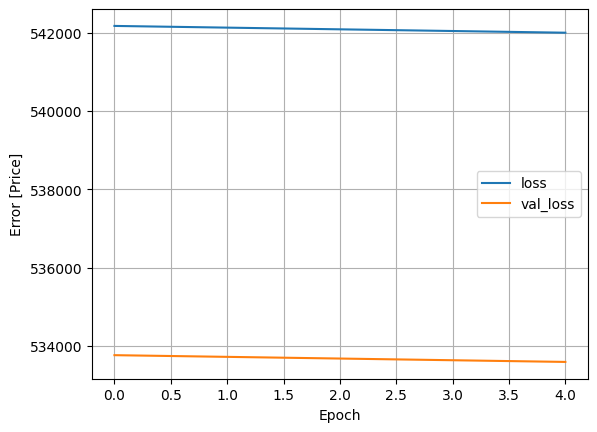

136/136 [==============================] - 1s 6ms/step - loss: 538149.5000
Epoch 1/5
541/541 [==============================] - 4s 8ms/step - loss: 542260.3125
Epoch 2/5
541/541 [==============================] - 4s 7ms/step - loss: 542205.6875
Epoch 3/5
541/541 [==============================] - 4s 7ms/step - loss: 542151.5625
Epoch 4/5
541/541 [==============================] - 4s 7ms/step - loss: 542096.9375
Epoch 5/5
136/136 [==============================] - 0s 3ms/step
Epoch 1/5
541/541 [==============================] - 4s 7ms/step - loss: 539816.3125
Epoch 2/5
541/541 [==============================] - 4s 7ms/step - loss: 539761.9375
Epoch 3/5
541/541 [==============================] - 4s 7ms/step - loss: 539707.6250
Epoch 4/5
541/541 [==============================] - 4s 7ms/step - loss: 539653.0625
Epoch 5/5
136/136 [==============================] - 0s 3ms/step
MAE from bias_variance lib [avg expected loss]: 650039.227
Avg Bias: 422550994132.785
Avg Variance: 2436.365


In [55]:
# Model for linear regression. Normalizing as first step with a single unit and layer to get a linear regression
linear_model = model_definition_compilation_fit(
    'linear model',
    layers=[
        normalizer,
        layers.Dense(units=1)
    ],
    learning_rate=0.1,
    epochs=5,
    validation_split=0.2
)

#### *Comparing linear regression predictions with real values*

136/136 [==============================] - 0s 3ms/step


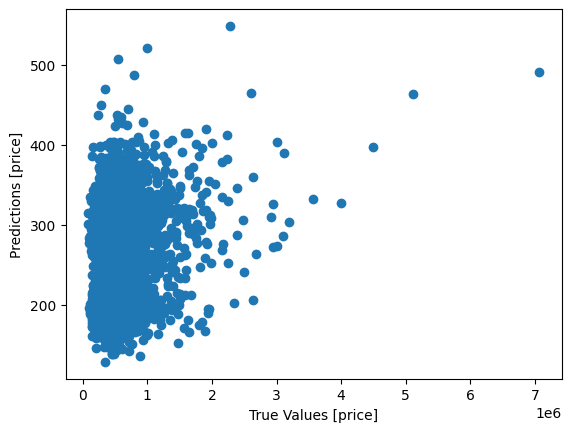

In [69]:
test_predictions = linear_model.predict(test_features).flatten()

plt.clf()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
plt.show()

#### ***Model 2: Simple neural network***

Epoch 1/5
433/433 [==============================] - 5s 12ms/step - loss: 170462.3594 - val_loss: 126651.7344
Epoch 2/5
433/433 [==============================] - 5s 11ms/step - loss: 131250.0781 - val_loss: 123041.8125
Epoch 3/5
433/433 [==============================] - 5s 12ms/step - loss: 128629.7656 - val_loss: 123624.9297
Epoch 4/5
433/433 [==============================] - 5s 11ms/step - loss: 127549.4062 - val_loss: 123643.2344
Epoch 5/5
433/433 [==============================] - 5s 11ms/step - loss: 126666.1953 - val_loss: 120848.7188


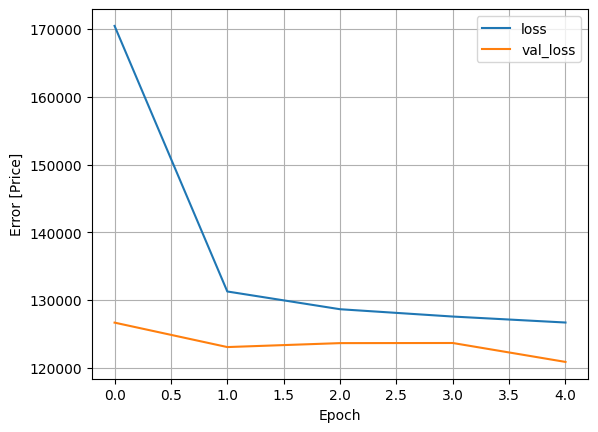

136/136 [==============================] - 1s 6ms/step - loss: 125409.2812
Epoch 1/5
541/541 [==============================] - 5s 9ms/step - loss: 149530.8906
Epoch 2/5
541/541 [==============================] - 5s 9ms/step - loss: 126265.4766
Epoch 3/5
541/541 [==============================] - 5s 9ms/step - loss: 125234.1328
Epoch 4/5
541/541 [==============================] - 5s 10ms/step - loss: 123480.8750
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
Epoch 1/5
541/541 [==============================] - 5s 9ms/step - loss: 156118.2656
Epoch 2/5
541/541 [==============================] - 5s 9ms/step - loss: 127582.3438
Epoch 3/5
541/541 [==============================] - 5s 9ms/step - loss: 125398.8672
Epoch 4/5
541/541 [==============================] - 5s 9ms/step - loss: 124038.8594
Epoch 5/5
136/136 [==============================] - 0s 4ms/step
MAE from bias_variance lib [avg expected loss]: 200682.196
Avg Bias: 39528040016.256
Avg Variance: 745303709.131


In [66]:
# Model for simple neural network. Normalizing as first step with two layers of intermediate computation and an output layer of a single cell
nn_model = model_definition_compilation_fit(
    'neural_net',
    layers=[
        normalizer,
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(1)
    ],
    learning_rate=0.1,
    epochs=5,
    validation_split=0.2
)

#### *Comparing simple neural network predictions with real values*

136/136 [==============================] - 1s 4ms/step


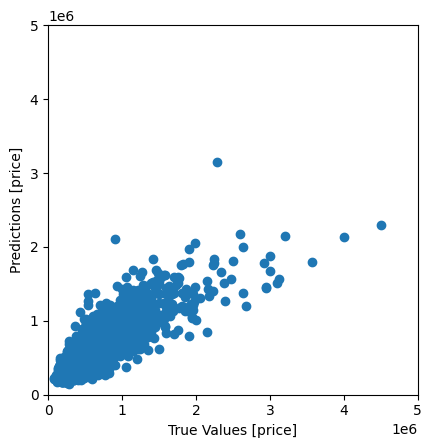

In [75]:
test_predictions = dropout_large_nn_model.predict(test_features).flatten()

plt.clf()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
plt.xlim((0,5e6))
plt.ylim((0,5e6))
plt.show()

---
## **Performance analysis**
After analyzing the error and the bias and the variance, it can be concluded that a neural network predicts better the relation between the independent variable and the dependent variables; and this makes sense, since we expect the performance of a neural network to be better than a simple regressio model.

--- 
## **Regularization of the model**
Having the neural network to work as the model for the prediction, we can now apply regularization techniques or adjustment of parameters to improve the performance of the neural network.
<br>There were made 3 changes in the hyperparameters:
- Large neural network (increasing the number of layers)
- Simple neural network with dropout layer (to reduce overfitting)
- Large neutal network with droput layers

#### ***Model 2a: Large neural network***
Increasing the number of layers

Epoch 1/5
433/433 [==============================] - 6s 13ms/step - loss: 158739.4219 - val_loss: 131224.1250
Epoch 2/5
433/433 [==============================] - 5s 13ms/step - loss: 138438.1406 - val_loss: 129895.8047
Epoch 3/5
433/433 [==============================] - 5s 12ms/step - loss: 134720.5312 - val_loss: 139795.8438
Epoch 4/5
433/433 [==============================] - 5s 12ms/step - loss: 133322.0625 - val_loss: 135773.2656
Epoch 5/5
433/433 [==============================] - 5s 12ms/step - loss: 130287.0469 - val_loss: 144444.0625


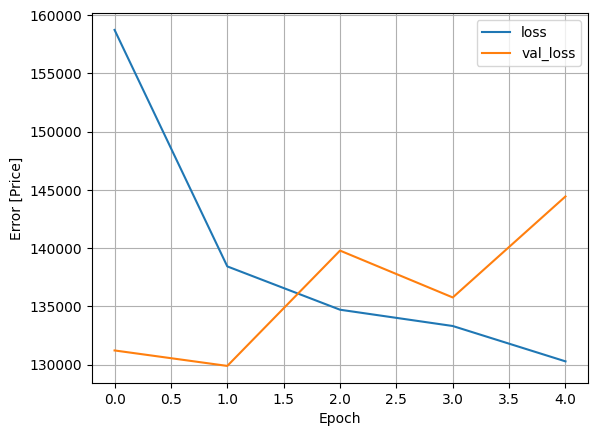

136/136 [==============================] - 1s 6ms/step - loss: 147103.8906
Epoch 1/5
541/541 [==============================] - 6s 11ms/step - loss: 165691.7656
Epoch 2/5
541/541 [==============================] - 6s 11ms/step - loss: 130538.1016
Epoch 3/5
541/541 [==============================] - 6s 11ms/step - loss: 128001.4375
Epoch 4/5
541/541 [==============================] - 7s 12ms/step - loss: 125521.9062
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
Epoch 1/5
541/541 [==============================] - 6s 10ms/step - loss: 151587.1406
Epoch 2/5
541/541 [==============================] - 5s 10ms/step - loss: 129863.7031
Epoch 3/5
541/541 [==============================] - 6s 11ms/step - loss: 129075.3906
Epoch 4/5
541/541 [==============================] - 6s 11ms/step - loss: 127503.2188
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
MAE from bias_variance lib [avg expected loss]: 196520.949
Avg Bias: 35862320909.224
Avg Variance: 27581625

In [67]:
# Model for big neural network. Normalizing as first step with four layers of intermediate computation and an output layer of a single cel
large_nn_model = model_definition_compilation_fit(
    'large_neural_net',
    layers=[
        normalizer,
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=1)
    ],
    learning_rate=0.1,
    epochs=5,
    validation_split=0.2
)

#### ***Model 2b: Simple neural network with dropout layer***
Adding a droput layer to avoid overfitting

Epoch 1/5
433/433 [==============================] - 5s 11ms/step - loss: 176616.3281 - val_loss: 129124.0000
Epoch 2/5
433/433 [==============================] - 5s 11ms/step - loss: 138943.2031 - val_loss: 124353.2969
Epoch 3/5
433/433 [==============================] - 5s 11ms/step - loss: 136801.8594 - val_loss: 123216.4609
Epoch 4/5
433/433 [==============================] - 5s 11ms/step - loss: 136271.9688 - val_loss: 120230.2656
Epoch 5/5
433/433 [==============================] - 5s 11ms/step - loss: 134919.8594 - val_loss: 121687.3594


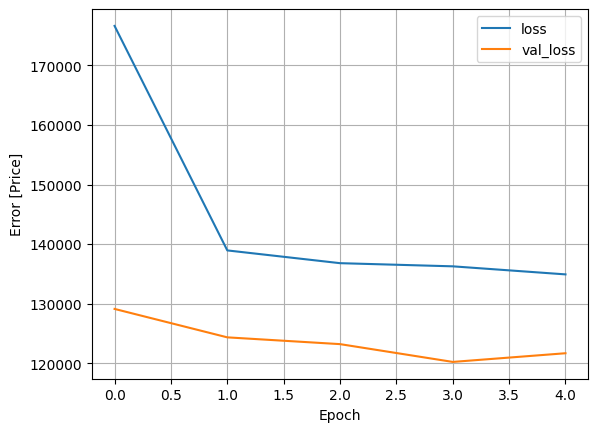

136/136 [==============================] - 1s 6ms/step - loss: 126640.9844
Epoch 1/5
541/541 [==============================] - 6s 10ms/step - loss: 154480.4219
Epoch 2/5
541/541 [==============================] - 5s 10ms/step - loss: 133061.4375
Epoch 3/5
541/541 [==============================] - 5s 10ms/step - loss: 132731.0781
Epoch 4/5
541/541 [==============================] - 5s 10ms/step - loss: 131794.5781
Epoch 5/5
136/136 [==============================] - 1s 3ms/step
Epoch 1/5
541/541 [==============================] - 5s 10ms/step - loss: 158529.4062
Epoch 2/5
541/541 [==============================] - 5s 10ms/step - loss: 134783.0469
Epoch 3/5
541/541 [==============================] - 5s 10ms/step - loss: 133167.8906
Epoch 4/5
541/541 [==============================] - 5s 10ms/step - loss: 132667.2188
Epoch 5/5
136/136 [==============================] - 0s 3ms/step
MAE from bias_variance lib [avg expected loss]: 206517.753
Avg Bias: 41870492374.931
Avg Variance: 77908992

In [60]:
# Model for simple neural network. Normalizing as first step with two layers of intermediate computation, 1 dropout layer (to reduce overfitting) and an output layer of a single cell
dropout_nn_model = model_definition_compilation_fit(
    'dropout_neural_net',
    layers=[
        normalizer,
        layers.Dropout(.1),
        layers.Dense(units=70, activation='relu'),
        layers.Dense(units=70, activation='relu'),
        layers.Dense(1)
    ],
    learning_rate=0.1,
    epochs=5,
    validation_split=0.2
)

#### ***Model 2c: Large neural network with dropout layers***
Increasing the number of layers and adding dropout layers

Epoch 1/5
433/433 [==============================] - 7s 15ms/step - loss: 169968.2500 - val_loss: 163441.4375
Epoch 2/5
433/433 [==============================] - 6s 14ms/step - loss: 146751.7969 - val_loss: 135591.3438
Epoch 3/5
433/433 [==============================] - 6s 14ms/step - loss: 146540.3438 - val_loss: 126241.2500
Epoch 4/5
433/433 [==============================] - 6s 14ms/step - loss: 143675.3125 - val_loss: 122736.1641
Epoch 5/5
433/433 [==============================] - 6s 15ms/step - loss: 144773.2031 - val_loss: 119325.7344


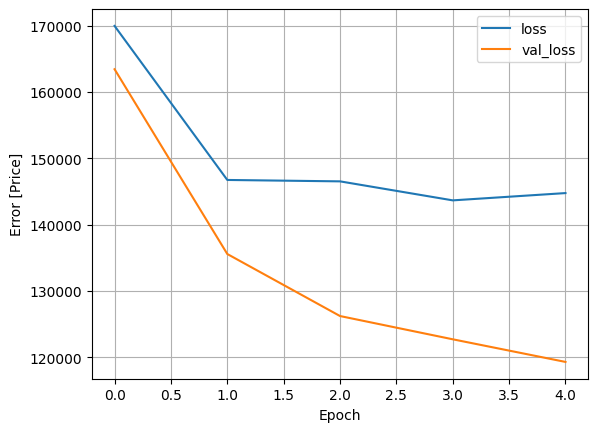

136/136 [==============================] - 1s 7ms/step - loss: 124418.4453
Epoch 1/5
541/541 [==============================] - 8s 14ms/step - loss: 167123.8281
Epoch 2/5
541/541 [==============================] - 8s 15ms/step - loss: 143861.3281
Epoch 3/5
541/541 [==============================] - 7s 12ms/step - loss: 141425.4062
Epoch 4/5
541/541 [==============================] - 6s 12ms/step - loss: 137358.8281
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
Epoch 1/5
541/541 [==============================] - 6s 12ms/step - loss: 162794.5781
Epoch 2/5
541/541 [==============================] - 6s 12ms/step - loss: 144412.1250
Epoch 3/5
541/541 [==============================] - 7s 12ms/step - loss: 138973.6562
Epoch 4/5
541/541 [==============================] - 6s 12ms/step - loss: 137590.0625
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
MAE from bias_variance lib [avg expected loss]: 223138.977
Avg Bias: 47653588671.503
Avg Variance: 21374144

In [61]:
# Model for big neural network. Normalizing as first step with four layers of intermediate computation, 3 dropout layers (to reduce overfitting due to the big size of the network) and an output layer of a single cel
dropout_large_nn_model = model_definition_compilation_fit(
    'dropout_large_neural_net',
    layers=[
        normalizer,
        layers.Dropout(.1),
        layers.Dense(units=40, activation='relu'),
        layers.Dropout(.02),
        layers.Dense(units=40, activation='relu'),
        layers.Dropout(.02),
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=40, activation='relu'),
        layers.Dense(units=1)
    ],
    learning_rate=0.1,
    epochs=5,
    validation_split=0.2
)

---
## **Validation of results**
Comparing all the models, we can conclude that the model that fits the best is the simple neural network since the mean absolute error, the bias and the variance are acceptable and it doesn't fall into overfitting or underfitting.

In [68]:
# Comparing MSE for the different models
display(pd.DataFrame(test_results, index=['Mean absolute error [price]']).T)

,Mean absolute error [price]
linear model,538149.500000
neural_net,125409.281250
large_neural_net,147103.890625
dropout_neural_net,126640.984375
dropput_large_neural_net,124418.445312


136/136 [==============================] - 1s 4ms/step


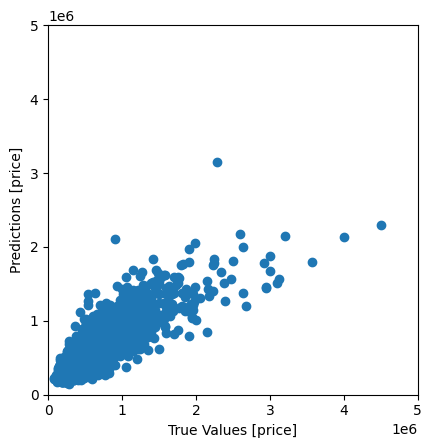

In [75]:
test_predictions = nn_model.predict(test_features).flatten()

plt.clf()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
plt.xlim((0,5e6))
plt.ylim((0,5e6))
plt.show()